### 1. 1D tracking
- state : position, velocity
- position은 noise 있다고 생각
- True trajectory와 Kalman estimate 비교하기

### 2. plotting
- 1> position tracking : 실제 궤적, noise 측정, kalman filter 추정
- 2> velocity estimation
- 3> uncertainty evolution (log scale)

### 3. uncertainty ellipse


## point 
1. prediction step 
2. update step
3. kalman gain
4. velocity : Position만 측정했는데 잘 추정함.

In [2]:
# module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

## Simulation parameter

In [3]:
dt = 0.1 # 시간 간격, 0.01, 0.1, 1 택
num_steps = 100 # 시뮬레이션 스텝 수
np.random.seed(60)

In [4]:
# 초기 상태
true_state = np.array([0.0, 1.0]) # 위치와 속도는 각각 0, 1

## system / real model / noise parameter

In [5]:
A = np.array([[1.0, dt], [0.0, 1.0]]) # system model
H = np.array([[1.0, 0.0]]) # real model
Q = np.array([[0.01, 0.0], [0.0, 0.01]]) # process noise cov
R = np.array([[1.0]]) # position measurement noise

## kalman filter reset

In [6]:
x_est = np.array([0.1, 0.7]) # 고의로 애매한 값으로 시작.
P = np.array([[1.0, 0.0], [0.0, 1.0]]) # 초기 공분산 행렬

## data's list

In [7]:
true_positions = [true_state[0]] # x and y must have same first dimension, but have shapes (100,) and (101,)
measurements = []
estimates = []
covariances = []

## simulation

In [8]:
for i in range(num_steps):
    '''
    1 실제 시스템 업데이트
    2 noise 측정값 생성하기
    3 칼만 필터로 prediction step 만들기
    4 칼만 필터 update step 만들기
    5 칼만 게인 설정
    6 상태랑 공분산 업데이트하기
    7 결과 저장하기
    '''
    # 1. 실제 시스템 업데이트
    process_noise = np.random.multivariate_normal([0.0, 0.0], Q) # ValueError: mean and cov must have same length
    true_state = A @ true_state + process_noise
    true_positions.append(true_state[0])
    
    # 2. noise 측정값 생성
    measurement_noise = np.random.normal(0, np.sqrt(R[0, 0]))
    z = H @ true_state + measurement_noise
    measurements.append(z[0])
    
    # 3. kalman / prediction step
    x_pred = A @ x_est 
    p_pred = A @ P @ A.T + Q #공분산 예측
    
    # 4.-6. kalman / update step
    y = z - H @ x_pred
    S = H @ p_pred @ H.T + R
    K = p_pred @ H.T @ np.linalg.inv(S) # kalman gain 식이다...
    x_est = x_pred + K @ y # 상태를 update
    P = (np.eye(2) - K @ H) @ p_pred
    
    # 7. 저장
    estimates.append(x_est.copy())
    covariances.append(P.copy())
    

In [9]:
estimates = np.array(estimates)
covariances = np.array(covariances)
true_positions = np.array(true_positions)

## plotting

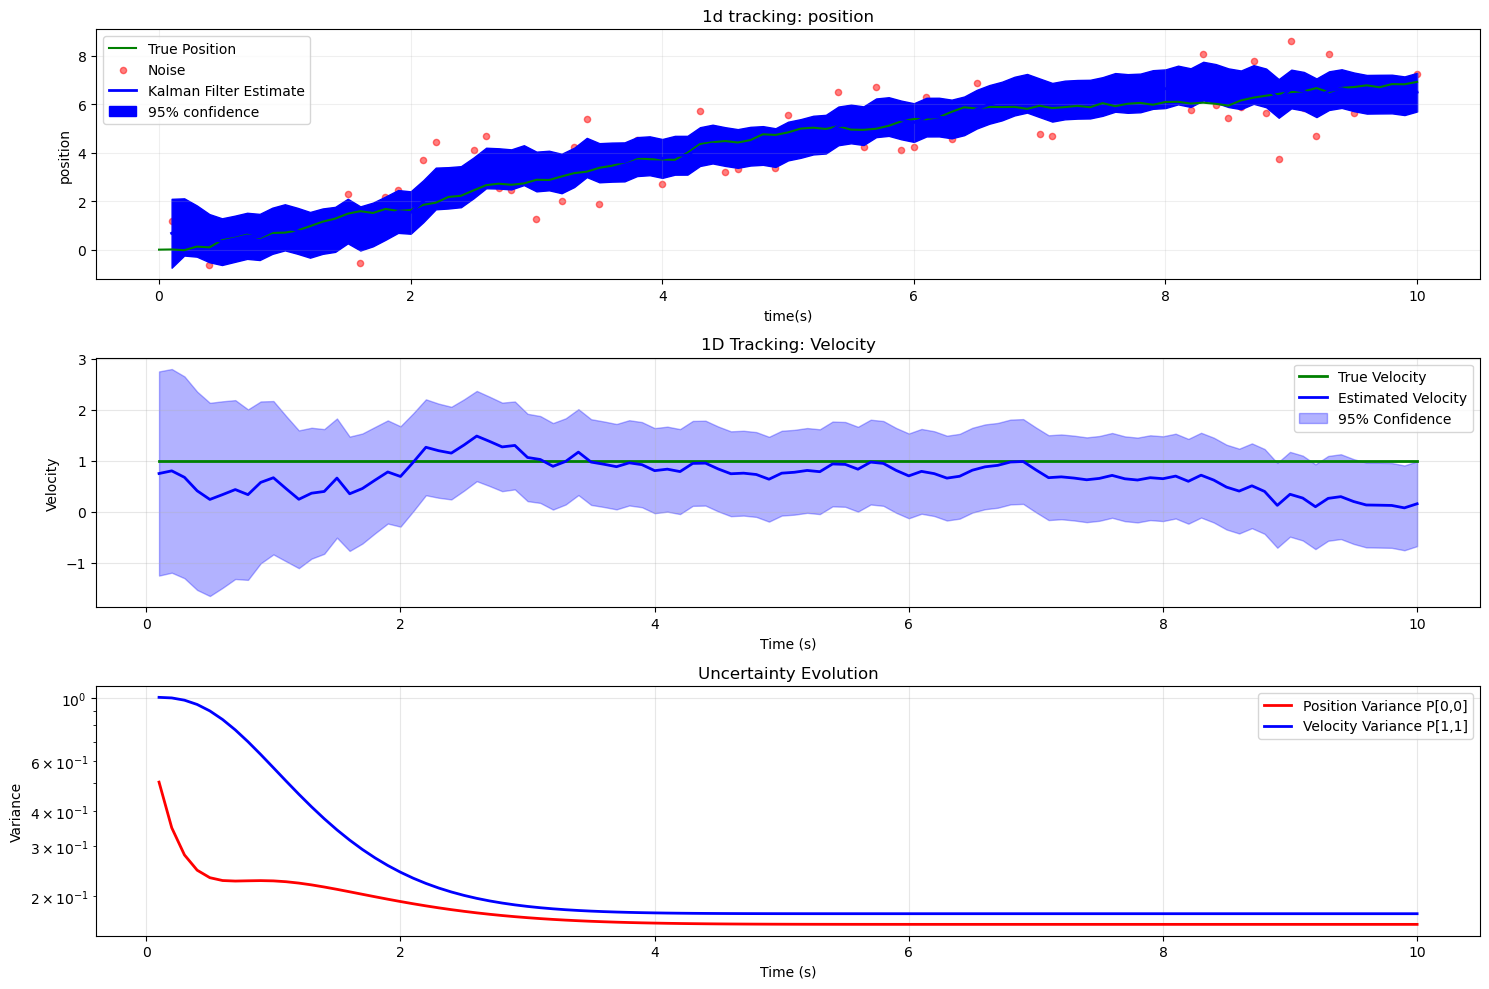

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

ax1 = axes[0]
time = np.arange(len(true_positions)) * dt
ax1.plot(time, true_positions, 'g-', label = 'True Position', linewidth = 1.5)
ax1.scatter(time[1:], measurements, label = 'Noise', c='r', alpha = 0.5, s = 20)
ax1.plot(time[1:], estimates[:, 0], 'b-', label = 'Kalman Filter Estimate', linewidth=2)
std_position = np.sqrt(covariances[:, 0, 0])
ax1.fill_between(time[1:], estimates[:, 0] - 2*std_position,
                 estimates[:, 0] + 2*std_position,
                 color='blue', label = '95% confidence')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('position')
ax1.set_title('1d tracking: position')
ax1.legend()
ax1.grid(True, alpha=0.2)



# 2. Velocity estimation
ax2 = axes[1]
true_velocity = [1.0] * num_steps  # 등속도
ax2.plot(time[1:], true_velocity, 'g-', label='True Velocity', linewidth=2)
ax2.plot(time[1:], estimates[:, 1], 'b-', label='Estimated Velocity', linewidth=2)

std_vel = np.sqrt(covariances[:, 1, 1])
ax2.fill_between(time[1:],
                  estimates[:, 1] - 2*std_vel,
                  estimates[:, 1] + 2*std_vel,
                  alpha=0.3, color='blue', label='95% Confidence')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity')
ax2.set_title('1D Tracking: Velocity')
ax2.legend()
ax2.grid(True, alpha=0.3)



# 3. 불확실성 변화 (공분산 행렬의 대각 성분)
ax3 = axes[2]
ax3.plot(time[1:], covariances[:, 0, 0], 'r-', label='Position Variance P[0,0]', linewidth=2)
ax3.plot(time[1:], covariances[:, 1, 1], 'b-', label='Velocity Variance P[1,1]', linewidth=2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Variance')
ax3.set_title('Uncertainty Evolution')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

plt.tight_layout()
plt.savefig('kalman_tracking_1d.png', dpi=150, bbox_inches='tight')
plt.show()

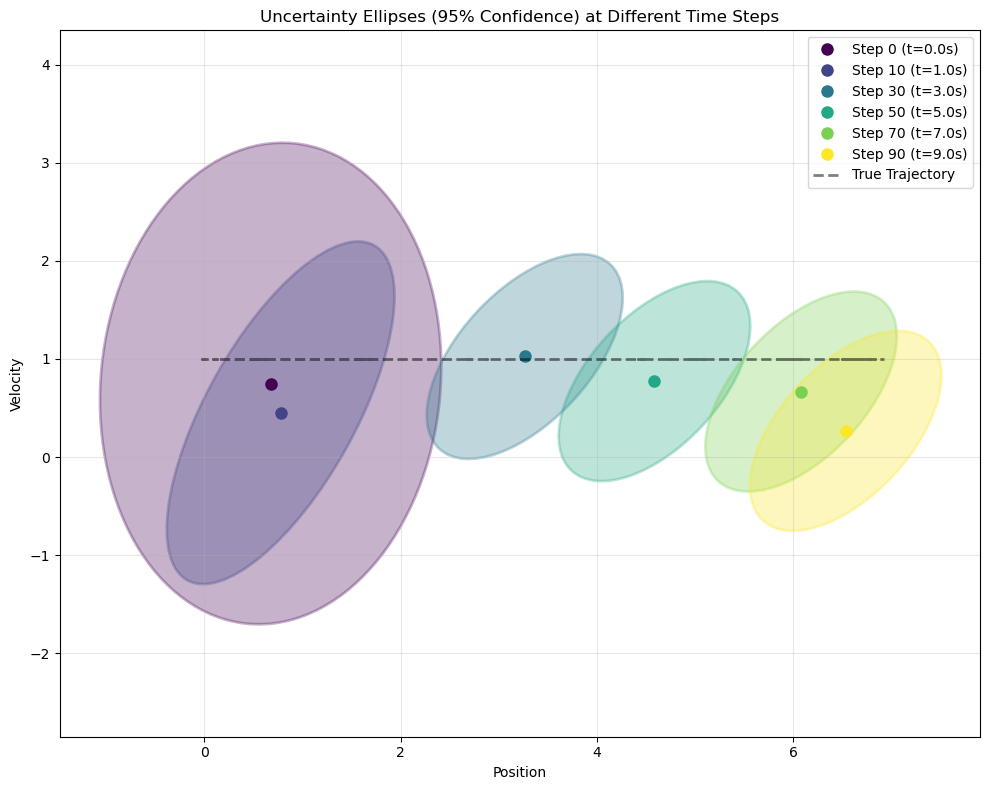

In [ ]:
fig2, ax = plt.subplots(1, 1, figsize=(10, 8))

selected_steps = [0, 10, 30, 50, 70, 90]
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_steps)))

for i, step in enumerate(selected_steps):
    if step >= num_steps:
        continue
    
    pos = estimates[step, 0]
    vel = estimates[step, 1]
    P_step = covariances[step]
    
    # 공분산 행렬에서 고유값과 고유벡터 구하기
    eigenvalues, eigenvectors = np.linalg.eig(P_step)
    
    # 타원의 장축과 단축 길이 (95% 신뢰구간: chi-square(2) = 5.991)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width = 2 * np.sqrt(5.991 * eigenvalues[0])
    height = 2 * np.sqrt(5.991 * eigenvalues[1])
    
    # 타원 그리기
    ellipse = Ellipse((pos, vel), width, height, angle=angle,
                     facecolor=colors[i], alpha=0.3, edgecolor=colors[i], linewidth=2)
    ax.add_patch(ellipse)
    
    # 중심점 표시
    ax.plot(pos, vel, 'o', color=colors[i], markersize=8, 
            label=f'Step {step} (t={step*dt:.1f}s)')

# True trajectory
ax.plot(true_positions, [1.0]*len(true_positions), 'k--', linewidth=2, 
        label='True Trajectory', alpha=0.5)

ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Uncertainty Ellipses (95% Confidence) at Different Time Steps')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.savefig('kalman_uncertainty_ellipses.png', dpi=150, bbox_inches='tight')
plt.show()